In [ ]:
from canns.models.brain_inspired import AmariHopfieldNetwork  # :cite:p:`amari1977neural,hopfield1982neural`
from canns.trainer import HebbianTrainer

# Create network
model = AmariHopfieldNetwork(num_neurons=784)  # 28x28 images

# Create trainer with Hebbian learning
trainer = HebbianTrainer(model, compiled_prediction=True)

# Train on patterns
trainer.train(pattern_list)

# Retrieve from corrupted input
output = trainer.predict(noisy_pattern)

In [ ]:
from canns.models.brain_inspired import AmariHopfieldNetwork

# Discrete activation (sign function): x ∈ {-1, +1}
model = AmariHopfieldNetwork(
    num_neurons=784,
    threshold=80.0,      # Convergence threshold
    asyn=False,          # Synchronous updates
    activation="sign"    # Binary states {-1, +1}
)

In [1]:
import numpy as np
from canns.models.brain_inspired import AmariHopfieldNetwork
from canns.trainer import HebbianTrainer

# Load MNIST data (automatically tries multiple sources)
def load_mnist_data():
    """Load MNIST using available library (datasets/torchvision/keras/sklearn)"""
    try:
        from datasets import load_dataset
        ds_train = load_dataset("mnist", split="train")
        x_train = np.stack([np.array(img, dtype=np.float32) for img in ds_train["image"]])
        y_train = np.array(ds_train["label"], dtype=np.int64)
        return x_train, y_train
    except:
        # Fallback to other sources...
        from torchvision.datasets import MNIST
        ds_train = MNIST(root="~/.cache/torchvision", train=True, download=True)
        x_train = ds_train.data.numpy().astype(np.float32)
        y_train = ds_train.targets.numpy().astype(np.int64)
        return x_train, y_train

x_train, y_train = load_mnist_data()
print(f"Loaded {len(x_train)} training images")

README.md: 0.00B [00:00, ?B/s]

mnist/train-00000-of-00001.parquet:   0%|          | 0.00/15.6M [00:00<?, ?B/s]

mnist/test-00000-of-00001.parquet:   0%|          | 0.00/2.60M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Loaded 60000 training images


In [2]:
def threshold_to_binary(image, use_mean=True):
    """Convert grayscale image to {-1, +1}"""
    if use_mean:
        threshold = image.mean()
    else:
        from skimage.filters import threshold_mean
        threshold = threshold_mean(image)

    binary = image > threshold
    return np.where(binary, 1.0, -1.0).astype(np.float32)

def flatten_image(image_2d):
    """Flatten 2D image to 1D vector"""
    return image_2d.reshape(-1)

# Select patterns to store (e.g., digits 0, 1, 2)
classes = [0, 1, 2]

# Get one training example per class
train_patterns = []
for digit in classes:
    # Find first occurrence of this digit
    idx = np.where(y_train == digit)[0][0]
    img_2d = x_train[idx]

    # Convert to binary and flatten
    binary = threshold_to_binary(img_2d)
    flat = flatten_image(binary)
    train_patterns.append(flat)

print(f"Prepared {len(train_patterns)} training patterns")
print(f"Pattern dimensions: {train_patterns[0].shape}")

Prepared 3 training patterns
Pattern dimensions: (784,)


In [3]:
# Create Hopfield network
n_neurons = train_patterns[0].size  # 784 for 28×28 images
model = AmariHopfieldNetwork(
    num_neurons=n_neurons,
    threshold=80.0,        # Max iterations for convergence
    asyn=False,            # Synchronous updates
    activation="sign"      # Binary activation
)

# Create Hebbian trainer
trainer = HebbianTrainer(
    model,
    compiled_prediction=True  # Use JIT compilation for speed
)

# Train on patterns (one-shot learning!)
print("Training network...")
trainer.train(train_patterns)
print("Training complete!")

Training network...
Training complete!


In [4]:
# Get test patterns (different examples of same digits)
test_patterns = []
for digit in classes:
    # Find second occurrence (different from training)
    idx = np.where(y_train == digit)[0][1]
    img_2d = x_train[idx]
    binary = threshold_to_binary(img_2d)
    flat = flatten_image(binary)
    test_patterns.append(flat)

# Retrieve patterns
print("Retrieving patterns...")
retrieved = trainer.predict_batch(
    test_patterns,
    show_sample_progress=True  # Show convergence progress
)

print(f"Retrieved {len(retrieved)} patterns")

Retrieving patterns...


Processing samples: 100%|█████████████| 3/3 [00:00<00:00,  6.89it/s, sample=3/3]

Retrieved 3 patterns


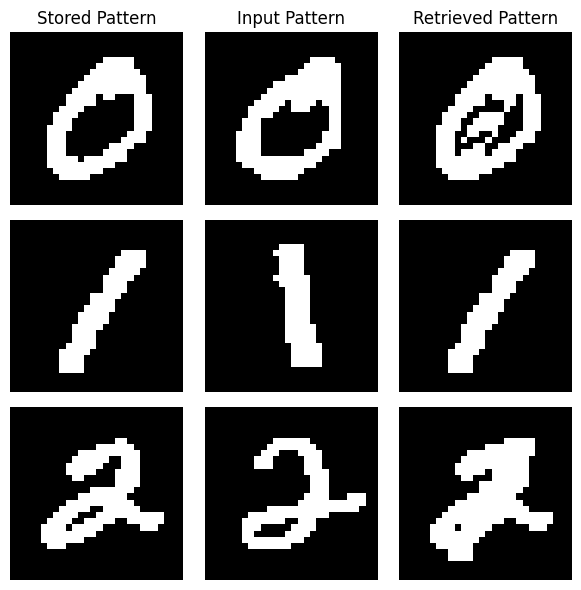

In [5]:
import matplotlib.pyplot as plt

def reshape_to_image(flat_vector):
    """Reshape 1D vector back to 2D image"""
    dim = int(np.sqrt(flat_vector.size))
    return flat_vector.reshape(dim, dim)

# Create visualization
fig, axes = plt.subplots(len(classes), 3, figsize=(6, 2*len(classes)))

for i in range(len(classes)):
    # Training pattern
    axes[i, 0].imshow(reshape_to_image(train_patterns[i]), cmap='gray')
    axes[i, 0].axis('off')
    if i == 0:
        axes[i, 0].set_title('Stored Pattern')

    # Test input
    axes[i, 1].imshow(reshape_to_image(test_patterns[i]), cmap='gray')
    axes[i, 1].axis('off')
    if i == 0:
        axes[i, 1].set_title('Input Pattern')

    # Retrieved pattern
    axes[i, 2].imshow(reshape_to_image(retrieved[i]), cmap='gray')
    axes[i, 2].axis('off')
    if i == 0:
        axes[i, 2].set_title('Retrieved Pattern')

plt.tight_layout()
plt.savefig('hopfield_mnist_retrieval.png', dpi=150)
plt.show()

In [6]:
def add_noise(pattern, noise_level=0.1):
    """Flip random bits with given probability"""
    noise_mask = np.random.random(pattern.shape) < noise_level
    noisy = pattern.copy()
    noisy[noise_mask] *= -1  # Flip sign
    return noisy

# Test with noisy inputs
noise_levels = [0.0, 0.1, 0.2, 0.3]

for noise in noise_levels:
    print(f"\nTesting with {int(noise*100)}% noise:")
    noisy_inputs = [add_noise(p, noise) for p in test_patterns]
    recovered = trainer.predict_batch(noisy_inputs)

    # Calculate accuracy (proportion of correct bits)
    accuracies = []
    for orig, recov in zip(train_patterns, recovered):
        accuracy = np.mean(orig == recov)
        accuracies.append(accuracy)

    print(f"  Mean accuracy: {np.mean(accuracies):.2%}")


Testing with 0% noise:


Processing samples: 100%|█████████████| 3/3 [00:00<00:00, 15.25it/s, sample=3/3]


  Mean accuracy: 97.07%

Testing with 10% noise:


Processing samples: 100%|█████████████| 3/3 [00:00<00:00, 15.36it/s, sample=3/3]


  Mean accuracy: 97.07%

Testing with 20% noise:


Processing samples: 100%|█████████████| 3/3 [00:00<00:00, 16.99it/s, sample=3/3]


  Mean accuracy: 97.07%

Testing with 30% noise:


Processing samples: 100%|█████████████| 3/3 [00:00<00:00, 15.49it/s, sample=3/3]

  Mean accuracy: 88.95%
